# HW2: Windy Gridworld with King's Moves

## 环境设置
- 网格：7行 × 10列
- 动作：8向移动（King's moves）
- 目标状态：(4,8) - episode结束
- 死亡状态：(1,10) - 奖励-100，episode结束
- 每步奖励：-1
- 风向：特定列有向上的风

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
import time

## 1. 环境定义

In [2]:
class WindyGridworld:
    def __init__(self, king_moves=True, absorbing_state=None):
        """
        初始化Windy Gridworld环境
        
        参数:
            king_moves: bool - 是否允许8向移动，False则只允许4向(Rook moves)
            absorbing_state: tuple - 吸收状态位置，如(1,4)，奖励+5
        """
        self.rows = 7
        self.cols = 10
        self.goal_state = (4, 8)  # 目标状态
        self.death_state = (1, 10)  # 死亡状态
        self.absorbing_state = absorbing_state  # 吸收状态（任务7）
        
        # 风向定义：列索引 -> 向上推的格数
        self.wind = {
            4: 1, 5: 1, 6: 1,  # 列4,5,6: 向上1格
            7: 2, 8: 2,        # 列7,8: 向上2格  
            9: 1               # 列9: 向上1格
        }
        
        # 动作定义
        if king_moves:
            # 8向移动（King's moves）
            self.actions = ['n', 'ne', 'e', 'se', 's', 'sw', 'w', 'nw']
            self.action_effects = {
                'n': (-1, 0), 'ne': (-1, 1), 'e': (0, 1), 'se': (1, 1),
                's': (1, 0), 'sw': (1, -1), 'w': (0, -1), 'nw': (-1, -1)
            }
        else:
            # 4向移动（Rook moves）
            self.actions = ['n', 'e', 's', 'w']
            self.action_effects = {
                'n': (-1, 0), 'e': (0, 1), 's': (1, 0), 'w': (0, -1)
            }
        
        # 所有状态
        self.states = [(r, c) for r in range(1, self.rows+1) 
                       for c in range(1, self.cols+1)]
    
    def step(self, state, action):
        """
        执行动作，返回下一个状态和奖励
        
        返回: (next_state, reward, done)
        """
        # 如果已经在终止状态，不能再移动
        if self.is_terminal(state):
            return state, 0, True
        
        row, col = state
        d_row, d_col = self.action_effects[action]
        
        # 应用动作
        new_row = row + d_row
        new_col = col + d_col
        
        # 应用风（只影响垂直方向）
        if new_col in self.wind:
            new_row -= self.wind[new_col]  # 风向上推
        
        # 边界检查
        new_row = max(1, min(self.rows, new_row))
        new_col = max(1, min(self.cols, new_col))
        
        next_state = (new_row, new_col)
        
        # 计算奖励
        if next_state == self.death_state:
            return next_state, -100, True
        elif next_state == self.absorbing_state:
            return next_state, 5, True
        elif next_state == self.goal_state:
            return next_state, -1, True  # 到达目标，但这步还是-1
        else:
            return next_state, -1, False
    
    def is_terminal(self, state):
        """判断是否为终止状态"""
        terminals = [self.goal_state, self.death_state]
        if self.absorbing_state:
            terminals.append(self.absorbing_state)
        return state in terminals
    
    def random_action(self):
        """随机选择一个动作"""
        return np.random.choice(self.actions)

## 2. SARSA 算法实现

In [3]:
def sarsa(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    SARSA算法 (on-policy)
    
    参数:
        env: WindyGridworld环境
        start_state: 起始状态
        episodes: 训练回合数
        alpha: 学习率
        gamma: 折扣因子
        epsilon: epsilon-greedy策略的探索率
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表
    Q = {(s, a): 0.0 for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    for episode in range(episodes):
        state = start_state
        
        # epsilon-greedy选择动作
        if np.random.random() < epsilon:
            action = env.random_action()
        else:
            action = max(env.actions, key=lambda a: Q[(state, a)])
        
        steps = 0
        
        while not env.is_terminal(state):
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # 选择下一个动作 (on-policy)
            if not done:
                if np.random.random() < epsilon:
                    next_action = env.random_action()
                else:
                    next_action = max(env.actions, key=lambda a: Q[(next_state, a)])
            else:
                next_action = None
            
            # SARSA更新
            if next_action is not None:
                Q[(state, action)] += alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            action = next_action
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

## 3. Q-Learning 算法实现

In [4]:
def q_learning(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    Q-Learning算法 (off-policy)
    
    参数同SARSA
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表
    Q = {(s, a): 0.0 for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    for episode in range(episodes):
        state = start_state
        steps = 0
        
        while not env.is_terminal(state):
            # epsilon-greedy选择动作
            if np.random.random() < epsilon:
                action = env.random_action()
            else:
                action = max(env.actions, key=lambda a: Q[(state, a)])
            
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # Q-Learning更新 (使用max)
            if not done:
                max_next_q = max(Q[(next_state, a)] for a in env.actions)
                Q[(state, action)] += alpha * (reward + gamma * max_next_q - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

## 4. 辅助函数

In [5]:
def get_optimal_policy(Q, env):
    """从Q表提取最优策略"""
    policy = {}
    for state in env.states:
        if not env.is_terminal(state):
            policy[state] = max(env.actions, key=lambda a: Q[(state, a)])
    return policy

def get_optimal_path(policy, env, start_state, max_steps=100):
    """根据策略生成从起点到终点的路径"""
    path = [start_state]
    state = start_state
    steps = 0
    
    while not env.is_terminal(state) and steps < max_steps:
        if state in policy:
            action = policy[state]
            next_state, _, _ = env.step(state, action)
            path.append(next_state)
            state = next_state
            steps += 1
        else:
            break
    
    return path

def plot_learning_curve(steps_list, title, labels):
    """绘制学习曲线"""
    plt.figure(figsize=(12, 6))
    
    for steps, label in zip(steps_list, labels):
        # 计算移动平均
        window = 100
        if len(steps) >= window:
            smoothed = np.convolve(steps, np.ones(window)/window, mode='valid')
            plt.plot(smoothed, label=label, alpha=0.8)
    
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode (smoothed)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_gridworld(env, path=None, policy=None):
    """可视化网格世界、路径和策略"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 绘制网格
    for r in range(1, env.rows + 1):
        for c in range(1, env.cols + 1):
            # 标记特殊状态
            if (r, c) == env.goal_state:
                ax.add_patch(Rectangle((c-1, env.rows-r), 1, 1, 
                                      facecolor='lightgreen', edgecolor='black'))
            elif (r, c) == env.death_state:
                ax.add_patch(Rectangle((c-1, env.rows-r), 1, 1, 
                                      facecolor='black', edgecolor='black'))
            elif (r, c) == env.absorbing_state:
                ax.add_patch(Rectangle((c-1, env.rows-r), 1, 1, 
                                      facecolor='lightblue', edgecolor='black'))
            else:
                ax.add_patch(Rectangle((c-1, env.rows-r), 1, 1, 
                                      facecolor='white', edgecolor='gray'))
    
    # 绘制风向箭头
    for col, strength in env.wind.items():
        x = col - 0.5
        y = -0.5
        ax.arrow(x, y, 0, strength*0.3, head_width=0.2, head_length=0.1, 
                fc='gray', ec='gray', alpha=0.6)
    
    # 绘制路径
    if path:
        path_x = [c - 0.5 for r, c in path]
        path_y = [env.rows - r + 0.5 for r, c in path]
        ax.plot(path_x, path_y, 'r-', linewidth=2, marker='o', 
               markersize=6, label='Optimal Path')
        # 标记起点
        ax.plot(path_x[0], path_y[0], 'go', markersize=12, label='Start')
    
    # 绘制策略箭头
    if policy:
        arrow_map = {
            'n': (0, 0.3), 'ne': (0.2, 0.2), 'e': (0.3, 0),
            'se': (0.2, -0.2), 's': (0, -0.3), 'sw': (-0.2, -0.2),
            'w': (-0.3, 0), 'nw': (-0.2, 0.2)
        }
        for state, action in policy.items():
            if state not in [env.goal_state, env.death_state, env.absorbing_state]:
                r, c = state
                dx, dy = arrow_map[action]
                x = c - 0.5
                y = env.rows - r + 0.5
                ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.05,
                        fc='blue', ec='blue', alpha=0.3)
    
    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.set_aspect('equal')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title('Windy Gridworld')
    if path:
        ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 任务1: 使用SARSA和Q-learning从三个起点找最优策略（8向移动）

任务1: 8向移动 (King's Moves)

起始位置: (7, 1)

运行 SARSA...
SARSA 最优路径长度: 8 步
SARSA 路径: [(7, 1), (6, 2), (7, 3), (6, 4), (6, 5), (6, 6), (5, 7), (4, 8)]

运行 Q-Learning...
Q-Learning 最优路径长度: 8 步
Q-Learning 路径: [(7, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (5, 7), (4, 8)]

生成可视化...


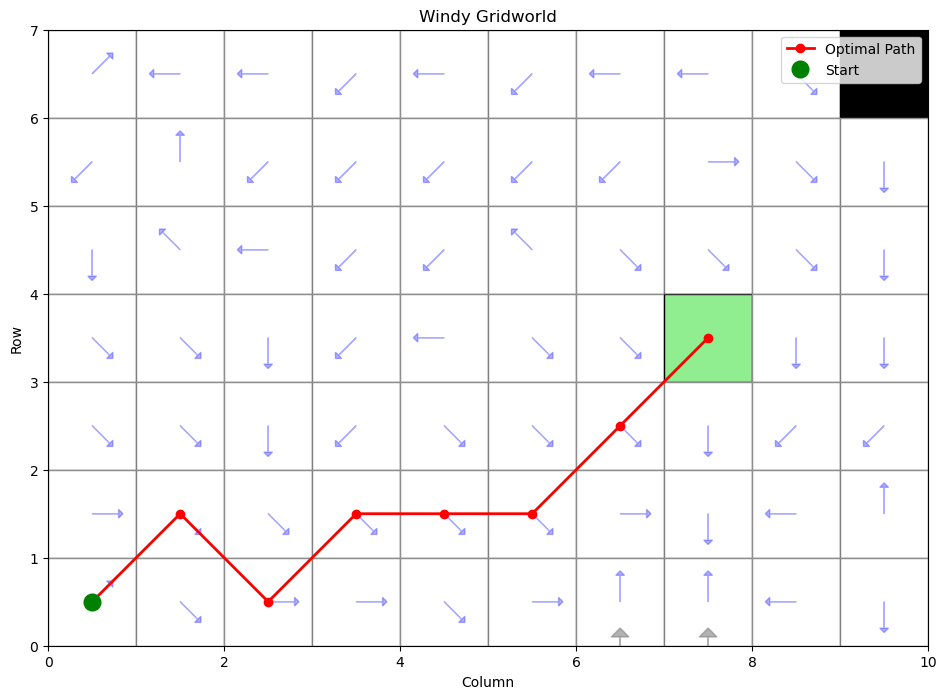

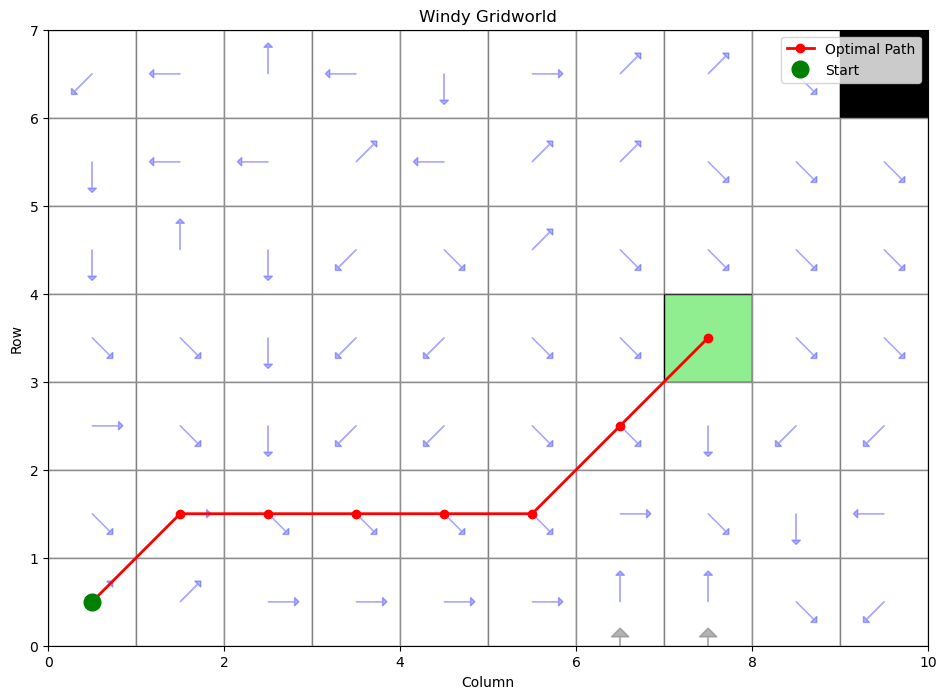


起始位置: (4, 1)

运行 SARSA...
SARSA 最优路径长度: 9 步
SARSA 路径: [(4, 1), (5, 2), (6, 3), (7, 3), (7, 4), (6, 5), (6, 6), (5, 7), (4, 8)]

运行 Q-Learning...
Q-Learning 最优路径长度: 8 步
Q-Learning 路径: [(4, 1), (5, 2), (6, 3), (6, 4), (6, 5), (6, 6), (5, 7), (4, 8)]

生成可视化...


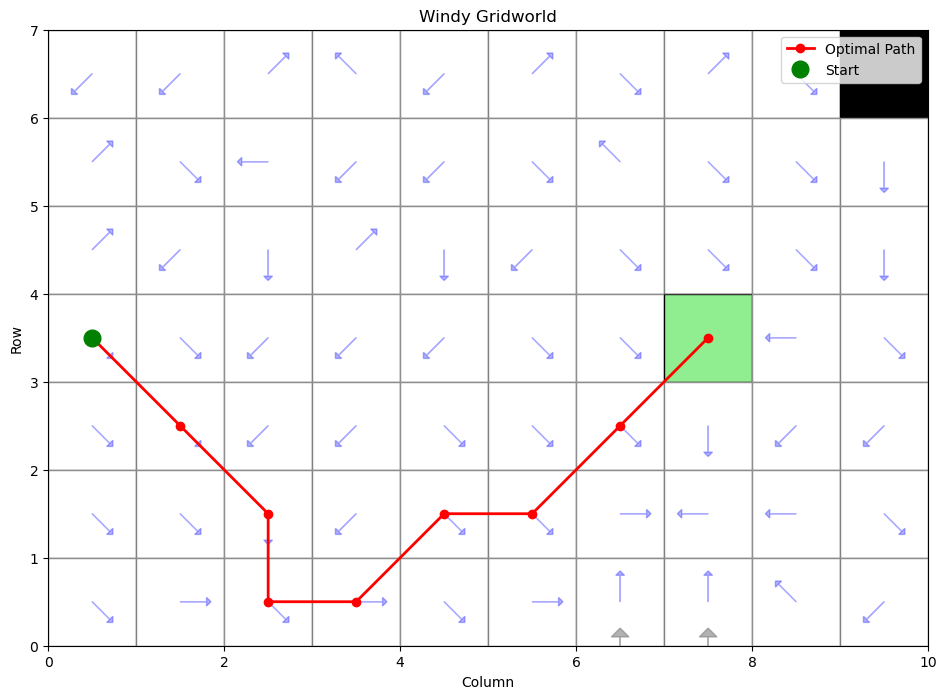

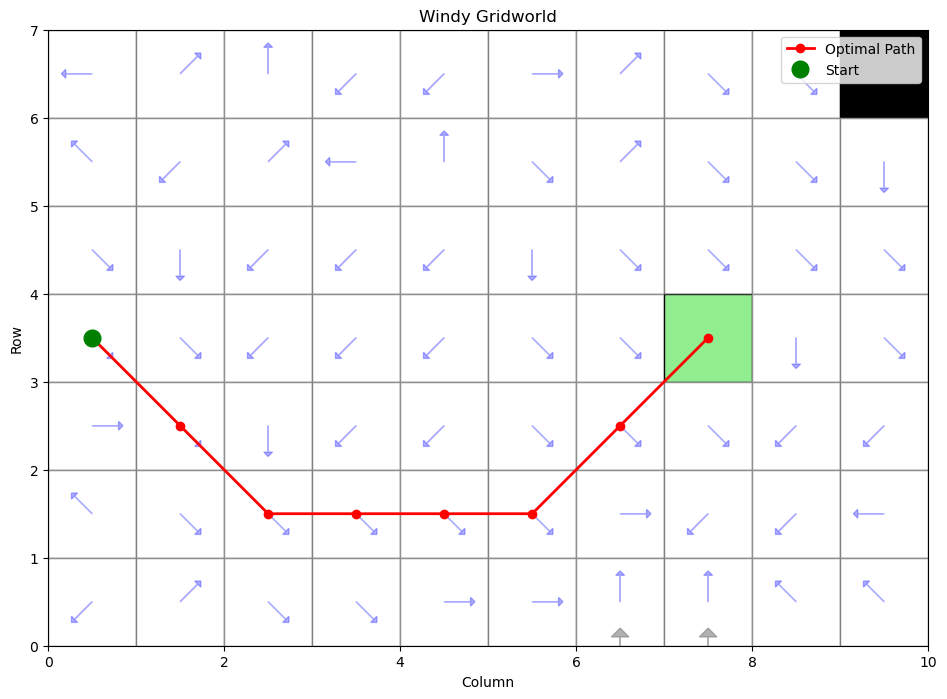


起始位置: (1, 7)

运行 SARSA...
SARSA 最优路径长度: 14 步
SARSA 路径: [(1, 7), (1, 6), (1, 5), (1, 4), (2, 3), (3, 2), (4, 3), (5, 3), (6, 3), (6, 4)]...

运行 Q-Learning...
Q-Learning 最优路径长度: 9 步
Q-Learning 路径: [(1, 7), (1, 8), (1, 9), (2, 10), (3, 10), (4, 10), (5, 10), (5, 9), (4, 8)]

生成可视化...


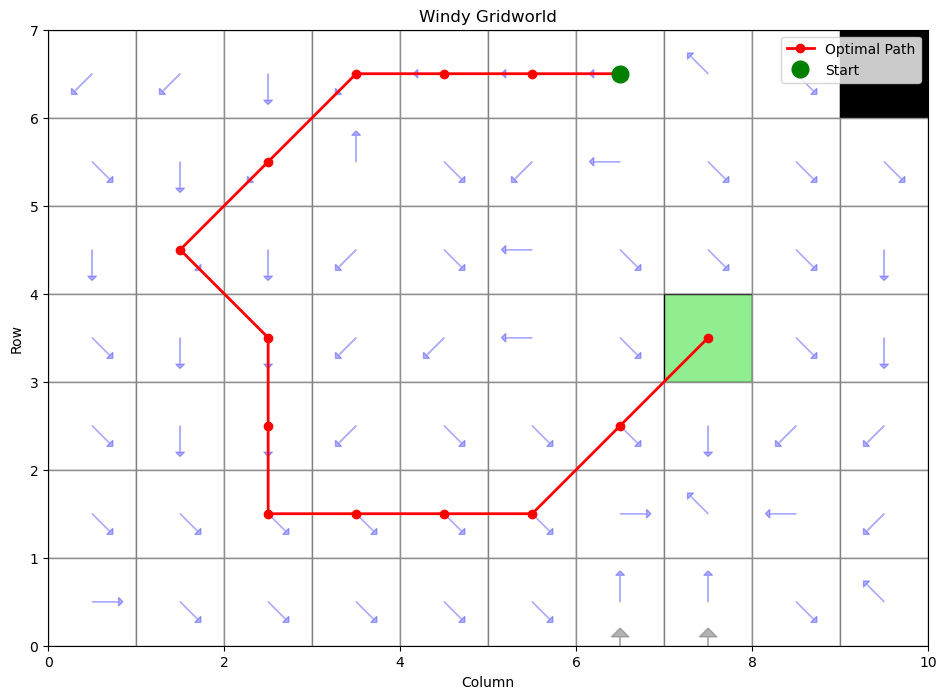

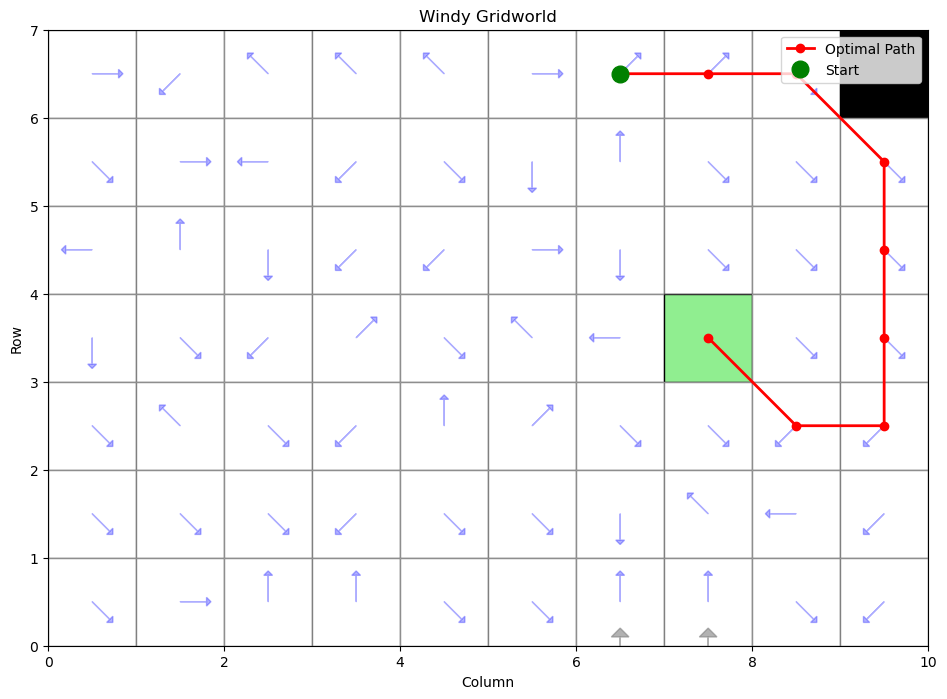

In [6]:
# 创建环境（8向移动）
env_king = WindyGridworld(king_moves=True)

# 三个起始位置
start_states = [(7, 1), (4, 1), (1, 7)]

print("=" * 60)
print("任务1: 8向移动 (King's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA...")
    Q_sarsa, steps_sarsa = sarsa(env_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa = get_optimal_policy(Q_sarsa, env_king)
    path_sarsa = get_optimal_path(policy_sarsa, env_king, start)
    print(f"SARSA 最优路径长度: {len(path_sarsa)} 步")
    print(f"SARSA 路径: {path_sarsa[:10]}..." if len(path_sarsa) > 10 else f"SARSA 路径: {path_sarsa}")
    
    # Q-Learning
    print("\n运行 Q-Learning...")
    Q_qlearn, steps_qlearn = q_learning(env_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_qlearn = get_optimal_policy(Q_qlearn, env_king)
    path_qlearn = get_optimal_path(policy_qlearn, env_king, start)
    print(f"Q-Learning 最优路径长度: {len(path_qlearn)} 步")
    print(f"Q-Learning 路径: {path_qlearn[:10]}..." if len(path_qlearn) > 10 else f"Q-Learning 路径: {path_qlearn}")
    
    # 可视化
    print("\n生成可视化...")
    visualize_gridworld(env_king, path=path_sarsa, policy=policy_sarsa)
    visualize_gridworld(env_king, path=path_qlearn, policy=policy_qlearn)

## 任务2: 仅允许Rook移动（4向移动）的对比

任务2: 4向移动 (Rook's Moves)

起始位置: (7, 1)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 10 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 10 步


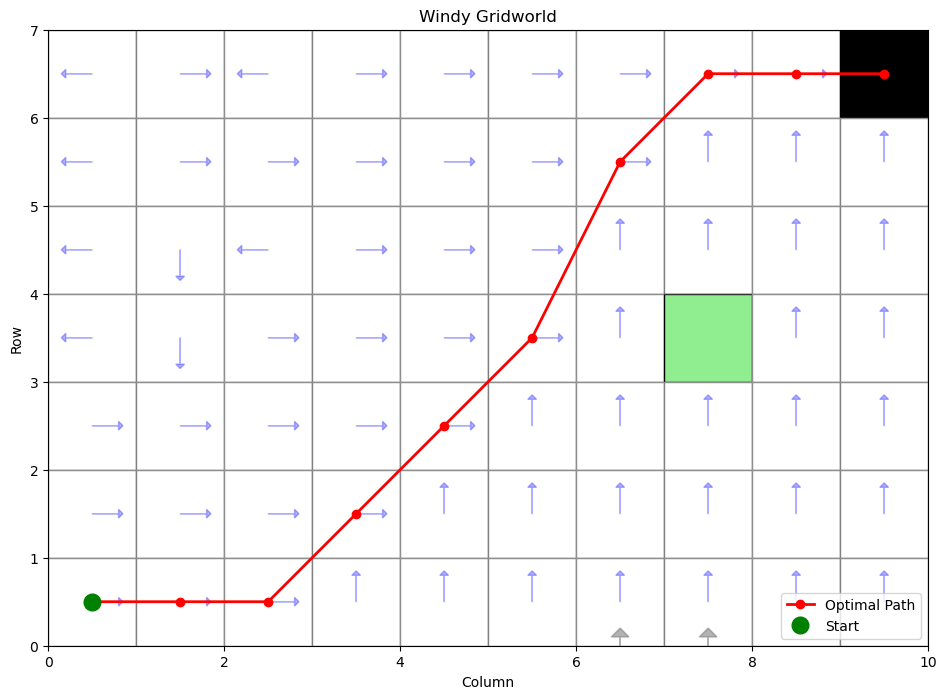


起始位置: (4, 1)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 10 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 10 步


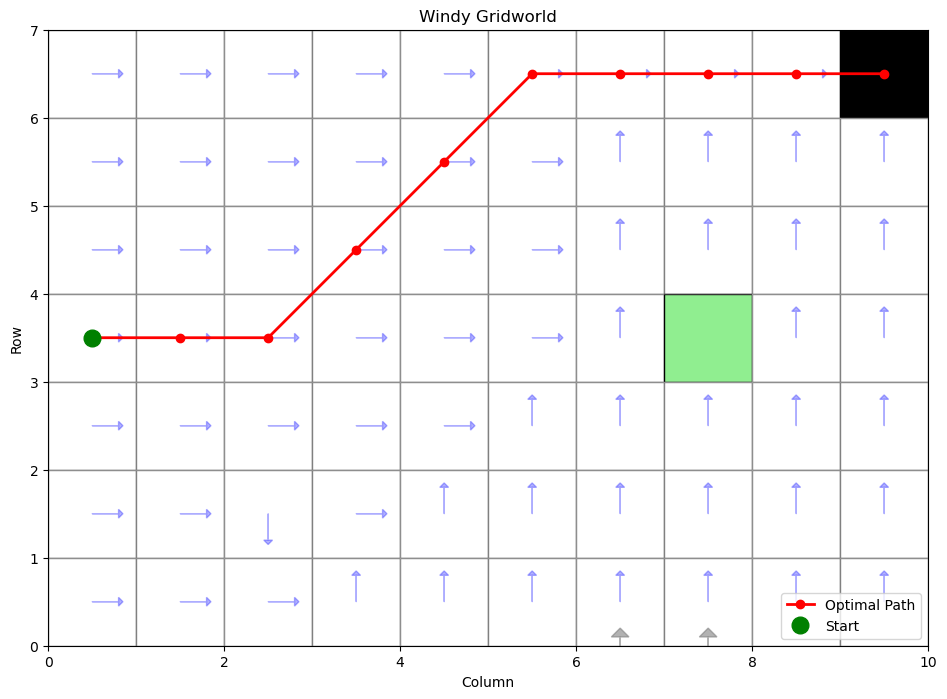


起始位置: (1, 7)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 4 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 4 步


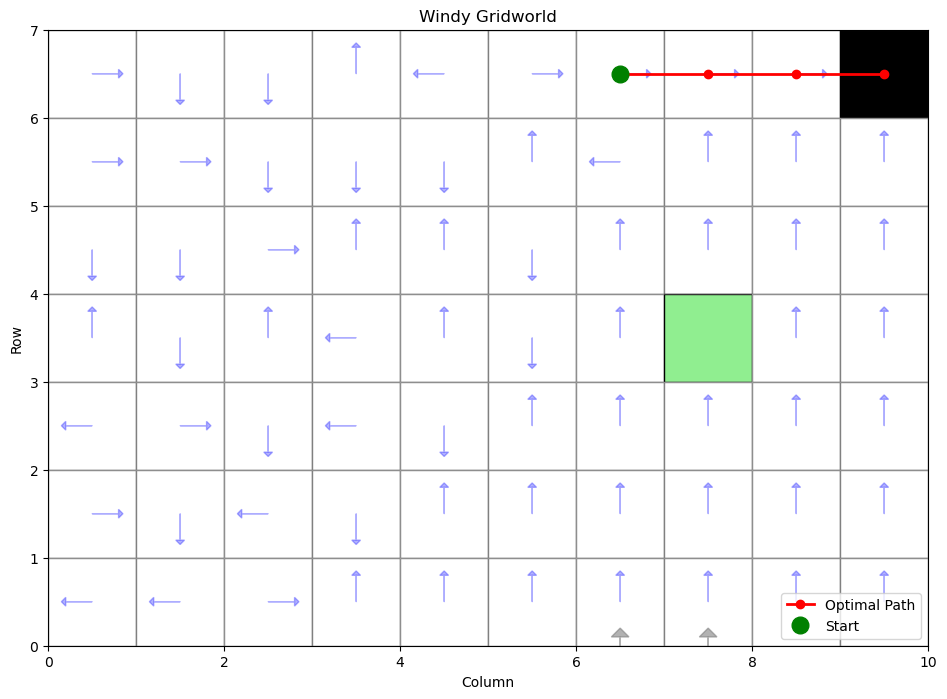

In [7]:
# 创建环境（4向移动）
env_rook = WindyGridworld(king_moves=False)

print("=" * 60)
print("任务2: 4向移动 (Rook's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA (4向)...")
    Q_sarsa_rook, steps_sarsa_rook = sarsa(env_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_rook = get_optimal_policy(Q_sarsa_rook, env_rook)
    path_sarsa_rook = get_optimal_path(policy_sarsa_rook, env_rook, start)
    print(f"SARSA (4向) 最优路径长度: {len(path_sarsa_rook)} 步")
    
    # Q-Learning
    print("\n运行 Q-Learning (4向)...")
    Q_qlearn_rook, steps_qlearn_rook = q_learning(env_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_qlearn_rook = get_optimal_policy(Q_qlearn_rook, env_rook)
    path_qlearn_rook = get_optimal_path(policy_qlearn_rook, env_rook, start)
    print(f"Q-Learning (4向) 最优路径长度: {len(path_qlearn_rook)} 步")
    
    # 可视化
    visualize_gridworld(env_rook, path=path_sarsa_rook, policy=policy_sarsa_rook)

## 任务7: 添加吸收状态(1,4)，奖励+5

任务7: 添加吸收状态(1,4)，奖励+5

8向移动 + 吸收状态

起始位置: (7, 1)
SARSA 路径长度: 5 步
路径: [(7, 1), (6, 2), (5, 3), (3, 4), (1, 4)]


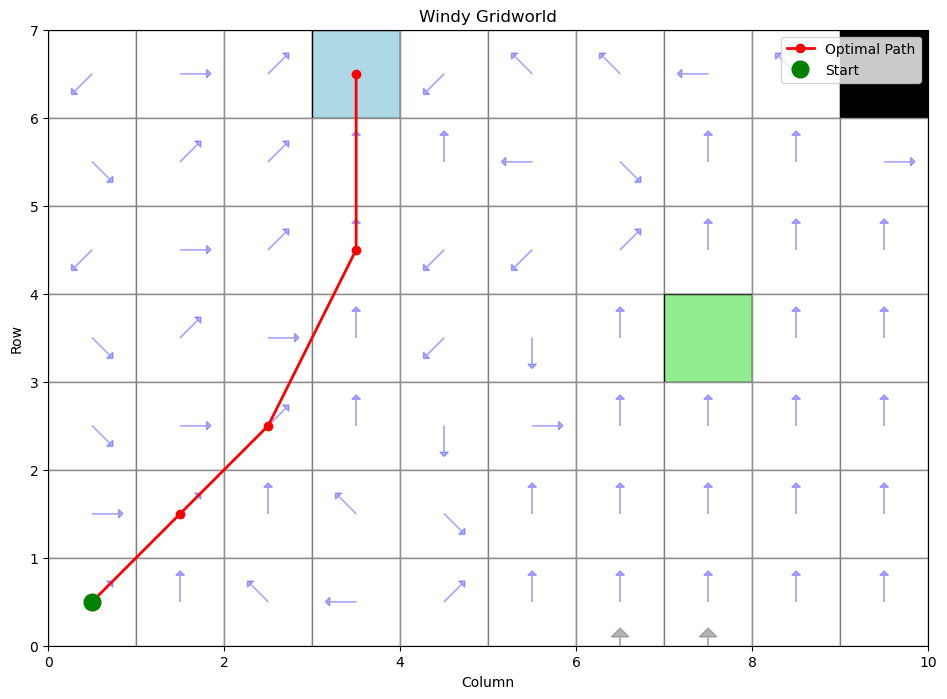


起始位置: (4, 1)
SARSA 路径长度: 4 步
路径: [(4, 1), (3, 2), (2, 3), (1, 4)]


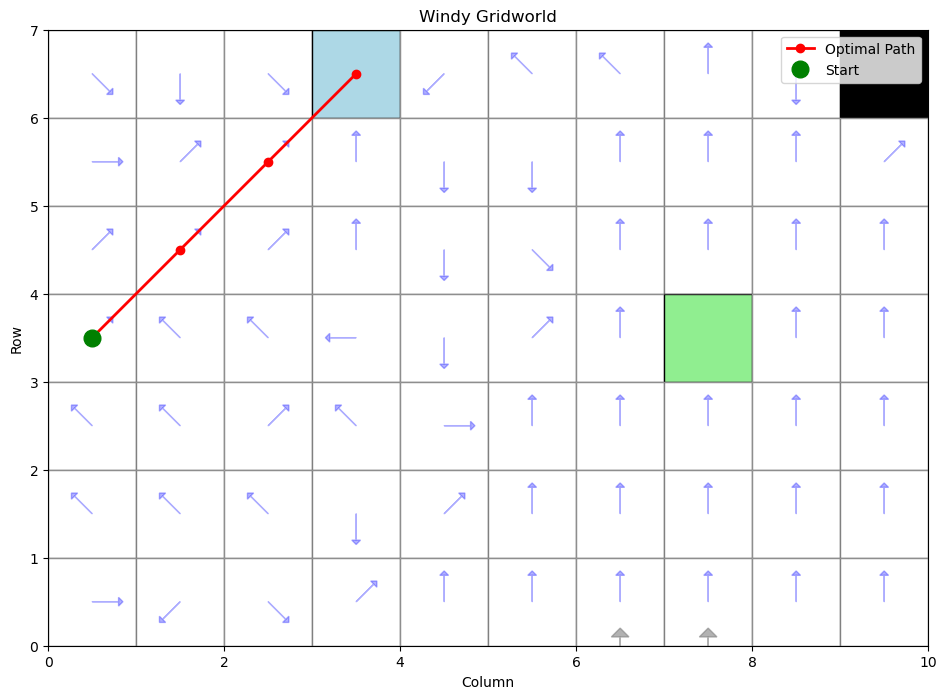


起始位置: (1, 7)
SARSA 路径长度: 4 步
路径: [(1, 7), (1, 6), (1, 5), (1, 4)]


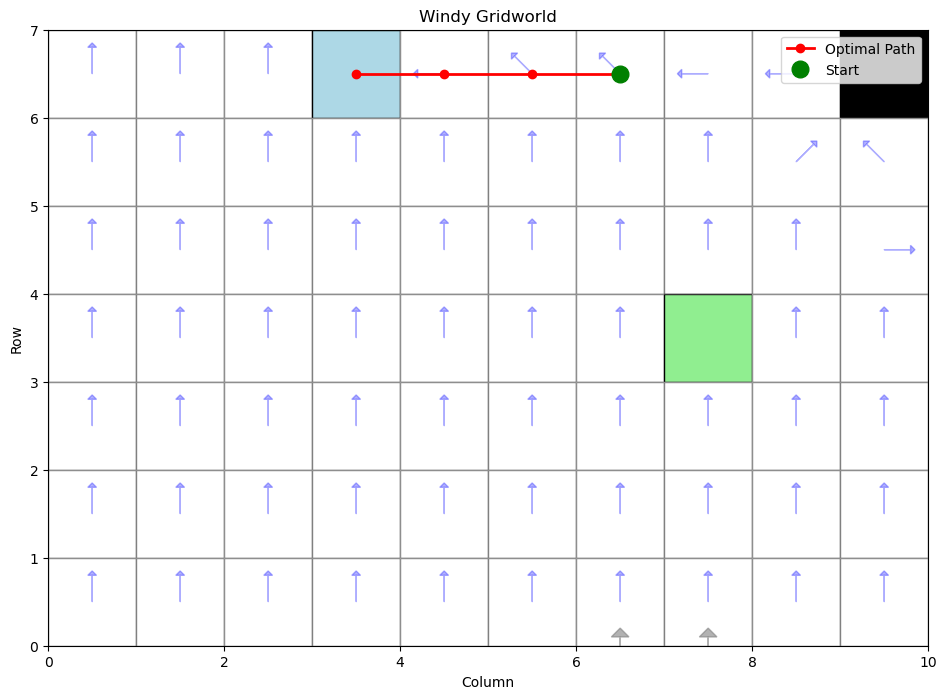


4向移动 + 吸收状态

起始位置: (7, 1)
SARSA 路径长度: 7 步
路径: [(7, 1), (7, 2), (6, 2), (6, 3), (5, 4), (3, 4), (1, 4)]


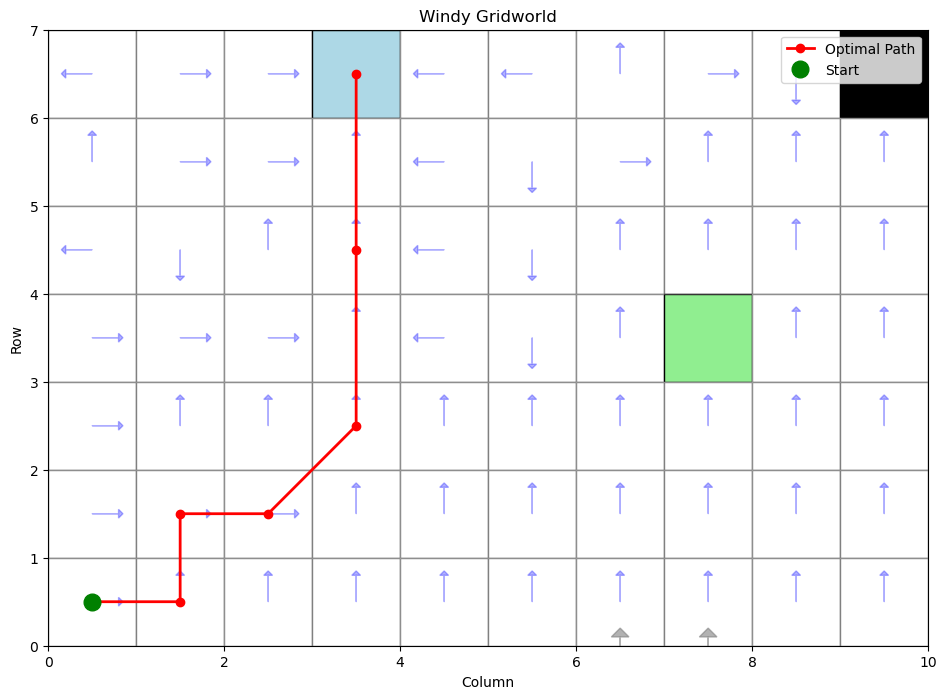


起始位置: (4, 1)
SARSA 路径长度: 5 步
路径: [(4, 1), (4, 2), (4, 3), (3, 4), (1, 4)]


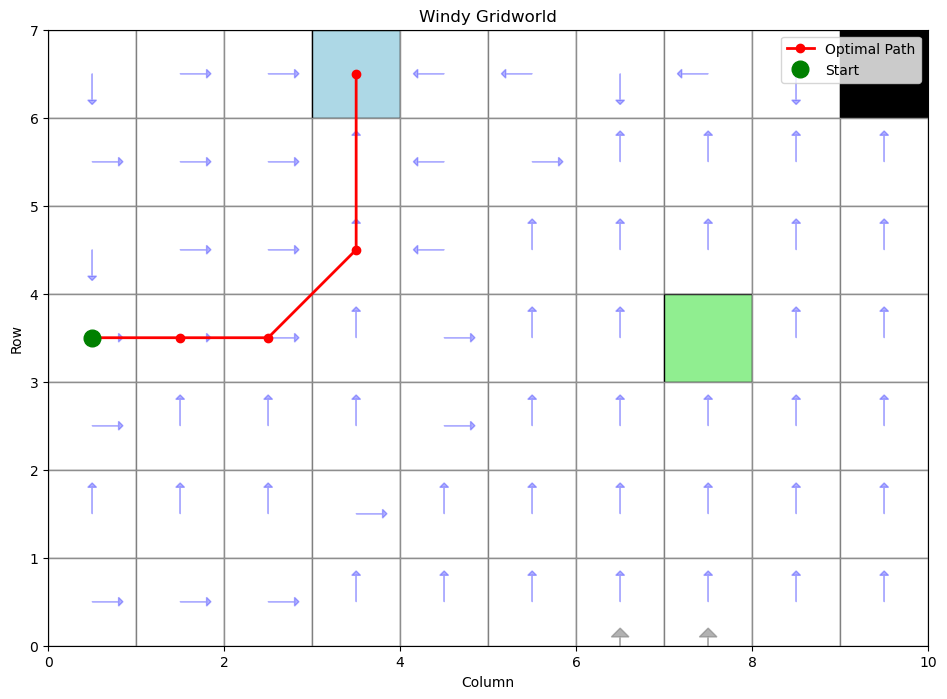


起始位置: (1, 7)
SARSA 路径长度: 4 步
路径: [(1, 7), (1, 6), (1, 5), (1, 4)]


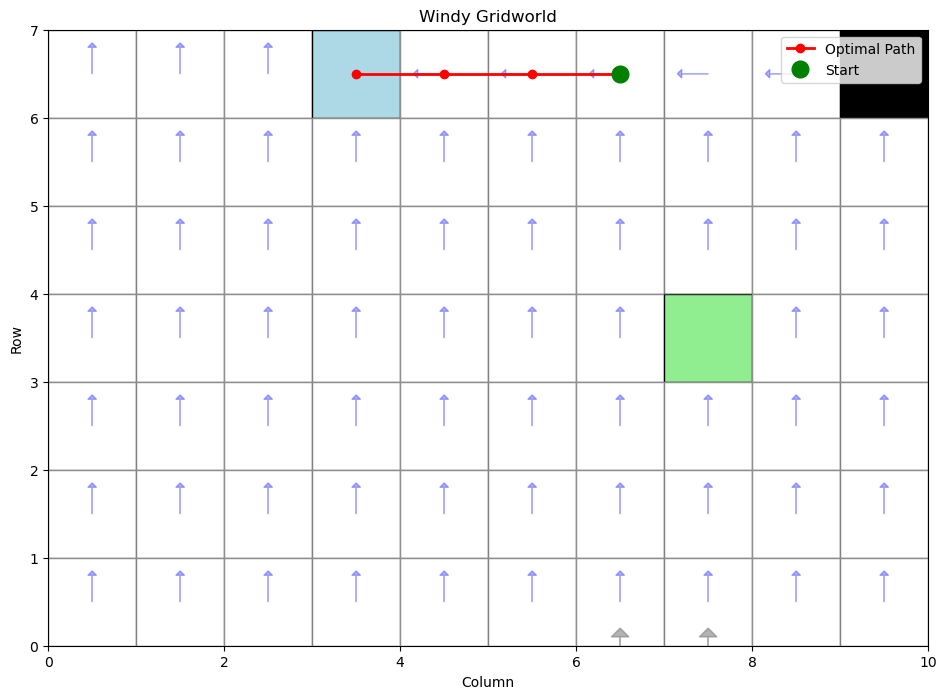

In [8]:
# 创建带吸收状态的环境
env_absorbing_king = WindyGridworld(king_moves=True, absorbing_state=(1, 4))
env_absorbing_rook = WindyGridworld(king_moves=False, absorbing_state=(1, 4))

print("=" * 60)
print("任务7: 添加吸收状态(1,4)，奖励+5")
print("=" * 60)

# 8向移动
print("\n" + "="*60)
print("8向移动 + 吸收状态")
print("="*60)

for start in start_states:
    print(f"\n起始位置: {start}")
    
    Q_sarsa_abs, _ = sarsa(env_absorbing_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs = get_optimal_policy(Q_sarsa_abs, env_absorbing_king)
    path_sarsa_abs = get_optimal_path(policy_sarsa_abs, env_absorbing_king, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs)} 步")
    print(f"路径: {path_sarsa_abs}")
    
    visualize_gridworld(env_absorbing_king, path=path_sarsa_abs, policy=policy_sarsa_abs)

# 4向移动  
print("\n" + "="*60)
print("4向移动 + 吸收状态")
print("="*60)

for start in start_states:
    print(f"\n起始位置: {start}")
    
    Q_sarsa_abs_rook, _ = sarsa(env_absorbing_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs_rook = get_optimal_policy(Q_sarsa_abs_rook, env_absorbing_rook)
    path_sarsa_abs_rook = get_optimal_path(policy_sarsa_abs_rook, env_absorbing_rook, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs_rook)} 步")
    print(f"路径: {path_sarsa_abs_rook}")
    
    visualize_gridworld(env_absorbing_rook, path=path_sarsa_abs_rook, policy=policy_sarsa_abs_rook)

## 对比分析

In [9]:
# 这里可以添加更多的对比分析和可视化
print("\n" + "="*60)
print("总结")
print("="*60)
print("\n1. SARSA vs Q-Learning:")
print("   - SARSA是on-policy算法，学习当前策略的价值")
print("   - Q-Learning是off-policy算法，学习最优策略的价值")
print("   - 在确定性环境中，两者应该收敛到相同的最优策略")
print("\n2. 8向 vs 4向移动:")
print("   - 8向移动允许对角线移动，路径更短")
print("   - 4向移动路径更长，但实现更简单")
print("\n3. 吸收状态的影响:")
print("   - 吸收状态(1,4)提供+5奖励")
print("   - 可能改变某些起点的最优策略")
print("   - 需要权衡：绕路获得+5 vs 直接到目标")


总结

1. SARSA vs Q-Learning:
   - SARSA是on-policy算法，学习当前策略的价值
   - Q-Learning是off-policy算法，学习最优策略的价值
   - 在确定性环境中，两者应该收敛到相同的最优策略

2. 8向 vs 4向移动:
   - 8向移动允许对角线移动，路径更短
   - 4向移动路径更长，但实现更简单

3. 吸收状态的影响:
   - 吸收状态(1,4)提供+5奖励
   - 可能改变某些起点的最优策略
   - 需要权衡：绕路获得+5 vs 直接到目标
